In [59]:
from pathlib import Path

project_dir = Path('.').absolute().parent
project_dir

PosixPath('/home/dtch1997/github/mcx-lab/rl-baselines3-zoo')

# Inspect logged inputs / outputs

Logs generated with `scripts/enjoy_with_logging.py`

In [60]:
import numpy as np
import pickle 
import json

def load_robot_states(stats_dir):
    base_rpy = np.load(stats_dir / 'base_rpy.npy')
    base_position = np.load(stats_dir / 'base_position.npy')
    base_velocity = np.load(stats_dir / 'base_velocity.npy')
    motor_position = np.load(stats_dir / 'motor_position.npy')
    motor_velocity = np.load(stats_dir / 'motor_velocity.npy')
    ref_displacement = np.load(stats_dir / 'reference_displacement.npy')
    act_displacement = np.load(stats_dir / 'actual_displacement.npy')
    ref_foot_contacts = np.load(stats_dir / 'reference_foot_contact.npy')
    act_foot_contacts = np.load(stats_dir / 'actual_foot_contact.npy')
    nn_observations = np.load(stats_dir / 'nn_observations.npy')

    reward_component_values = np.load(stats_dir / 'reward_components.npy')
    with open(stats_dir / 'reward_component_names.json', 'r') as file:
        reward_component_names = json.load(file)
    print(nn_observations.shape)
    nn_actions = np.load(stats_dir / 'nn_actions.npy')
    time = np.load(stats_dir / 'time.npy')
    
    return {
        'time': time, 
        'base_rpy': base_rpy,
        'base_pos': base_position,
        'base_vel': base_velocity,
        'motor_pos': motor_position, 
        'motor_vel': motor_velocity, 
        'ref_displacement': ref_displacement,
        'act_displacement': act_displacement,
        'ref_foot_contacts': ref_foot_contacts, 
        'act_foot_contacts': act_foot_contacts, 
        'nn_obs': nn_observations,
        'nn_act': nn_actions,
        'reward_component_values': reward_component_values,
        'reward_component_names': reward_component_names
    }

def load_normalizer(model_dir):
    with open(model_dir / 'A1GymEnv-v0' / 'vecnormalize.pkl', 'rb') as file:
        normalizer = pickle.load(file)
    return normalizer

In [61]:
model_dir = project_dir / 'logs' / 'ppo' / 'A1GymEnv-v0_44'
foot_names = ['FR', 'FL', 'RR', 'RL']

stats_dirs = [
    model_dir / 'trot-1.5Hz-0.6mps-flat',
    model_dir / 'trot-2.0Hz-0.6mps-flat',
    model_dir / 'trot-2.5Hz-0.6mps-flat',
    model_dir / 'trot-3.0Hz-0.6mps-flat',
]

statss = [load_robot_states(sd) for sd in stats_dirs]
normalizer = load_normalizer(model_dir)

(1000, 1, 108)
(1000, 1, 108)
(1000, 1, 108)
(1000, 1, 108)


# Plot Reference / Actual Foot Contacts

In [62]:
import matplotlib.pyplot as plt

google_blue = (66 / 256, 133 / 256, 244 / 256, 1)
google_red = (219 / 256, 68 / 256, 55 / 256, 1)
google_yellow = (244 / 256, 180 / 256, 0, 1)
google_green = (15 / 256, 157 / 256, 88 / 256, 1)

foot_names = ['FR', 'FL', 'RR', 'RL']
foot_colors = [google_blue, google_red, google_yellow, google_green]

def plot_foot_contacts(ax, time, foot_contacts, title):
    
    ax.set_yticks([0,1,2,3])
    ax.set_yticklabels(foot_names)
    for i in range(4):
        # Select timesteps where foot is on ground
        ground_idx = foot_contacts[:,i] == 1
        ax.set_title(title)
        ax.axhline(y=i+0.5, color='black', linestyle='--')
        ax.fill_between(time, i-0.3, i+0.3, where=ground_idx, color = foot_colors[i])


[0.86968 0.86176 0.8304  0.85104]
[0.91056 0.84764 0.89548 0.88116]
[0.8614  0.88044 0.8736  0.86276]
[0.85316 0.88148 0.8028  0.8358 ]


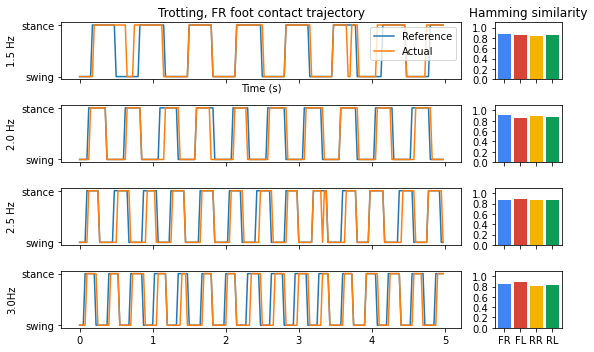

In [63]:
NUM_TIMESTEPS = 200

def calc_hamming_sim(stats, stats_dir):
    time = stats['time']
    ref_foot_contacts = stats['ref_foot_contacts']
    act_foot_contacts = stats['act_foot_contacts']

    # Divide by 2 since binary entries are [-1, 1] and not [0,1]
    diff = np.abs(ref_foot_contacts - act_foot_contacts) / 2
    hamming_dist = np.mean(diff, axis=0)
    hamming_sim = 1 - hamming_dist
    return hamming_sim

def plot_foot_contact_sequence(ax, stats, stats_dir, foot_index = 0, prefix=""):
    import matplotlib.pyplot as plt 
    
    time = stats['time']
    ref_foot_contacts = stats['ref_foot_contacts']
    act_foot_contacts = stats['act_foot_contacts']
    act_foot_contacts = 2 * (act_foot_contacts > 0) - 1
    
    # fig.suptitle(stats_dir.name)
    
    hamming_sim = calc_hamming_sim(stats, stats_dir)
    print(hamming_sim)

    ax[0].set_ylabel(f"{prefix}")
    ax[0].plot(time[:NUM_TIMESTEPS], ref_foot_contacts[:NUM_TIMESTEPS, foot_index], label = 'Reference')
    ax[0].plot(time[:NUM_TIMESTEPS], act_foot_contacts[:NUM_TIMESTEPS, foot_index], label = 'Actual')
    ax[0].set_yticks([-1,1])
    ax[0].set_yticklabels(['swing', 'stance'])

    # Plot hamming similarity
    ax[1].set_ylim(0.0, 1.1)
    ax[1].set_yticks([i / 5 for i in range(0, 6)])
    ax[1].set_xticks([0,1,2,3])
    ax[1].set_xticklabels(foot_names)
    ax[1].bar([0,1,2,3], hamming_sim, color = foot_colors)

fig, ax = plt.subplots(4, 2, figsize=(8,5), gridspec_kw={'width_ratios':(6,1)}, sharex='col')
ax[0,0].set_title("Trotting, FR foot contact trajectory")
ax[0,0].set_xlabel("Time (s)")
ax[0,1].set_title("Hamming similarity")
prefixes = ('1.5 Hz', '2.0 Hz', '2.5 Hz', '3.0Hz')
for i, (stats, stats_dir) in enumerate(zip(statss, stats_dirs)):
    plot_foot_contact_sequence(ax[i], stats, stats_dir, prefix=prefixes[i])
ax[0,0].legend()
fig.tight_layout()
fig.savefig("ref_act_foot_contact_4x1.pdf", format="pdf", bbox_inches="tight")
    

# Generate 2x2 Layout

[0.86968 0.86176 0.8304  0.85104]
[0.91056 0.84764 0.89548 0.88116]
[0.8614  0.88044 0.8736  0.86276]
[0.85316 0.88148 0.8028  0.8358 ]


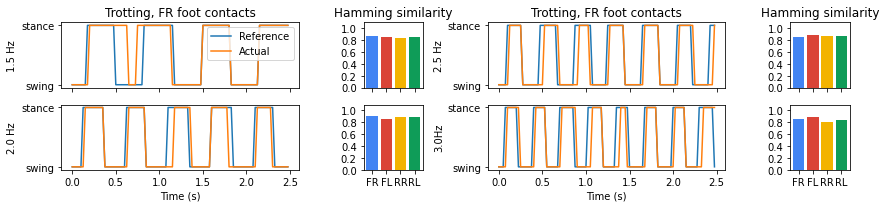

In [65]:
NUM_TIMESTEPS = 100

def calc_hamming_sim(stats, stats_dir):
    time = stats['time']
    ref_foot_contacts = stats['ref_foot_contacts']
    act_foot_contacts = stats['act_foot_contacts']

    # Divide by 2 since binary entries are [-1, 1] and not [0,1]
    diff = np.abs(ref_foot_contacts - act_foot_contacts) / 2
    hamming_dist = np.mean(diff, axis=0)
    hamming_sim = 1 - hamming_dist
    return hamming_sim

def plot_foot_contact_sequence(ax, ax_row, ax_col, stats, stats_dir, foot_index = 0, prefix=""):
    import matplotlib.pyplot as plt 
    
    time = stats['time']
    ref_foot_contacts = stats['ref_foot_contacts']
    act_foot_contacts = stats['act_foot_contacts']
    act_foot_contacts = 2 * (act_foot_contacts > 0) - 1
    
    # fig.suptitle(stats_dir.name)
    
    hamming_sim = calc_hamming_sim(stats, stats_dir)
    print(hamming_sim)

    ax[ax_row, ax_col].set_ylabel(f"{prefix}")
    ax[ax_row, ax_col].plot(time[:NUM_TIMESTEPS], ref_foot_contacts[:NUM_TIMESTEPS, foot_index], label = 'Reference')
    ax[ax_row, ax_col].plot(time[:NUM_TIMESTEPS], act_foot_contacts[:NUM_TIMESTEPS, foot_index], label = 'Actual')
    ax[ax_row, ax_col].set_yticks([-1,1])
    ax[ax_row, ax_col].set_yticklabels(['swing', 'stance'])

    # Plot hamming similarity
    ax[ax_row, ax_col+1].set_ylim(0.0, 1.1)
    ax[ax_row, ax_col+1].set_yticks([i / 5 for i in range(0, 6)])
    ax[ax_row, ax_col+1].set_xticks([0,1,2,3])
    ax[ax_row, ax_col+1].set_xticklabels(foot_names)
    ax[ax_row, ax_col+1].bar([0,1,2,3], hamming_sim, color = foot_colors)

fig, ax = plt.subplots(2, 4, figsize=(12,3), gridspec_kw={'width_ratios':(4,1,4,1)}, sharex='col')
ax[0,0].set_title("Trotting, FR foot contacts")
ax[1,0].set_xlabel("Time (s)")
ax[0,1].set_title("Hamming similarity")
ax[0,2].set_title("Trotting, FR foot contacts")
ax[1,2].set_xlabel("Time (s)")
ax[0,3].set_title("Hamming similarity")
prefixes = ('1.5 Hz', '2.0 Hz', '2.5 Hz', '3.0Hz')
ax_idxes = [(0,0), (1,0), (0,2), (1,2)]
for i, (stats, stats_dir) in enumerate(zip(statss, stats_dirs)):
    plot_foot_contact_sequence(ax, ax_idxes[i][0], ax_idxes[i][1], stats, stats_dir, prefix=prefixes[i])
ax[0,0].legend()
fig.tight_layout()
fig.savefig("ref_act_foot_contact_2x2.pdf", format="pdf", bbox_inches="tight")
    